# Notebook 2 : UK data analysis + LDA + Filtering the top 20 newspapers

In [ ]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')


## 1. Filter out the non relevant tags and subdomains of the top 20 domains + Notebook 1 cleaning :

* the table with the top 20 domains and their relevant tags can be found under "domain filtering.pdf"

In [2]:
relevant= ["bbc.co.uk/news/",
"Ablink.editorial.theguardian.com",
"theguardian.com/news/",
"theguardian.com/world/",
"theguardian.com/commentisfree/",
"theguardian.com/us-news/",
"theguardian.com/uk-news/",
"theguardian.com/politics/",
"theguardian.com/education/",
"theguardian.com/society/",
"theguardian.com/science/",
"theguardian.com/business/",
"theguardian.com/money/",
"theguardian.com/sport/",
"theguardian.com/australia-news/",
"theguardian.com/travel/",
"theguardian.com/technology/",
"theguardian.com/commentisfree/",
"dailymail.co.uk/news/",
"dailymail.co.uk/columnists/",
"dailymail.co.uk/debate/",
"dailymail.co.uk/femail/",
"dailymail.co.uk/health/",
"dailymail.co.uk/money/",
"dailymail.co.uk/sport/",
"dailymail.co.uk/travel/",
"dailymail.co.uk/tvshowbiz/",
"news.sky.com/story/",
"thesun.co.uk/fabulous/",
"thesun.co.uk/money/",
"thesun.co.uk/news/",
"thesun.co.uk/sport/",
"thesun.co.uk/travel/",
"thesun.co.uk/tech/",
"www.telegraph.co.uk/politics/",
"www.telegraph.co.uk/news/",
"express.co.uk",
"metro.co.uk",
"itv.com/news",
"independent.co.uk/news",
"thetimes.co.uk/article",
"www.channel4.com/news",
"inews.co.uk/news",
"thetelegraphandargus.co.uk/news",
"nytimes.com/20",
"standard.co.uk/news",
"kentonline.co.uk",
"ft.com/content",
"eveningtimes.co.uk/news",
"eveningtimes.co.uk/content"]

In [3]:
news = pd.DataFrame()
DATA_FILES = ['uk/newspaper.json']
for filepath in DATA_FILES:
    current_news = pd.read_json(filepath, lines=True)
    current_news['country'] = filepath[:2]
    news = news.append(current_news)
    

news.reset_index(inplace=True, drop=True)

In [4]:
media_portals= news[(news['meta_lang'] == 'en') | (news['meta_lang'].isnull())] #select only articles with 'en' meta_lang or with empty

In [5]:
media_portals=media_portals[media_portals.url.str.contains('|'.join(relevant))]

In [6]:
media_portals=media_portals[media_portals["url"].str.contains("express.co.uk/showbiz|discountcode.metro.co.uk|Link.news.metro.co.uk|www.metro.co.uk|api.metro.co.uk")==False]
media_portals

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk
7,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
8,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
20,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk
21,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
120568,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk
120569,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk
120576,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk
120579,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk


## check how many articles we have with all the tags from the top 20:

In [8]:
alltwenty= ["bbc.co.uk",
"theguardian.com",
"dailymail.co.uk",
"sky.com",
"thesun.co.uk",
"www.telegraph.co.uk",
"express.co.uk",
"metro.co.uk",
"itv.com",
"independent.co.uk",
"thetimes.co.uk",
"www.channel4.com",
"inews.co.uk",
"thetelegraphandargus.co.uk",
"nytimes.com",
"standard.co.uk",
"kentonline.co.uk",
"ft.com",
"eveningtimes.co.uk",
"buzzfeed.com"]

In [9]:
len(news[news.url.str.contains('|'.join(alltwenty))])

86346

## Checking the number of occurences of articles based on title and text seperately :

In [10]:
news[news.text.str.contains("That's why our new email newsletter will deliver a mobile-friendly snapshot of inews.co.uk", case=False, na=False)]

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1146,Mendip House care home has been fined a deriso...,The i's Essential Daily Briefing\n\nWe know th...,[Ian Birrell],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_74657_web_page.html,inews.co.uk/opinion/columnists/mendip-house-au...,NaN,uk
1172,The lesbian ‘blood sisters’ who cared for gay ...,The i's Essential Daily Briefing\n\nWe know th...,[Dr Kate Lister],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78007_web_page.html,inews.co.uk/opinion/comment/the-lesbian-blood-...,NaN,uk
1173,‘There were days we couldn’t buy food’: why as...,The i's Essential Daily Briefing\n\nWe know th...,[Nahla Ellozi],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78008_web_page.html,inews.co.uk/opinion/why-asylum-seekers-should-...,NaN,uk
2595,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8058_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
2596,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8059_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
93204,Michael Gove to challenge Boris Johnson for To...,The i's Essential Daily Briefing\n\nWe know th...,[Nick Duffy],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_23048_web_page.html,inews.co.uk/news/politics/michael-gove-to-chal...,NaN,uk
93502,Can UK enter Eurovision after Brexit? How leav...,The i's Essential Daily Briefing\n\nWe know th...,[Charlie Duffield],[https://edition.pagesuite-professional.co.uk/...,None,en,[],GER_2019-05-26_43942_web_page.html,inews.co.uk/news/brexit/eurovision-2019-brexit...,NaN,uk
93503,Matt Hancock warns the next Prime Minister not...,The i's Essential Daily Briefing\n\nWe know th...,[Georgina Littlejohn],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_43943_web_page.html,inews.co.uk/news/matt-hancock-warns-next-prime...,NaN,uk
93600,Nigel Farage ‘will take over’ as leader of the...,The i's Essential Daily Briefing\n\nWe know th...,[Serina Sandhu],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_48204_web_page.html,inews.co.uk/news/nigel-farage-leader-brexit-pa...,NaN,uk


In [11]:
pd.DataFrame(media_portals.text.value_counts())

text
The i's Essential Daily Briefing\n\nWe know tha...   349
What term do you want to search? Search with go...   278
Make informed decisions with the FT\n\nKeep abr...   171
Have Your Say                                         56
i Search\n\nCheck the URL for errors or try our...    52
...                                                  ...
Advertisement\n\nShe was recently named as the ...     1
The man who was falsely accused of murdering Ra...     1
Image copyright Family picture Image caption Wi...     1
Media playback is unsupported on your device Me...     1
FIREFIGHTERS put out a blaze in two cars on Idl...     1

[30193 rows x 1 columns]

In [12]:
media_portals['txt_counts'] = media_portals['text'].map(media_portals['text'].value_counts())
media_portals['title_counts'] = media_portals['title'].map(media_portals['title'].value_counts())

In [15]:
criteria=25
s=media_portals[media_portals['txt_counts']<=criteria]
print("Number of articles with text occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[media_portals['title_counts']<=criteria]
print("Number of articles with title occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[(media_portals['txt_counts']<=criteria) & (media_portals['title_counts']<=criteria)]
print("Number of articles with title and text occurence combined less than "+ str(criteria) +" :" + str(len(s)))
s.reset_index(inplace=True, drop=True)

Number of articles with text occurence less than 25 :36314
Number of articles with title occurence less than 25 :37252
Number of articles with title and text occurence combined less than 25 :36092


## Data preprocessing :

In [17]:
a=s
a.drop_duplicates(subset='text', keep='first')

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts
0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0
1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0
3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0
4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0
5,Quiz of the Week: How is Bond going green?,It's the weekly news quiz - have you been payi...,None,[https://sb.scorecardresearch.com/p?c1=2&c2=17...,None,en,[],GER_2019-03-15_2098_web_page.html,www.bbc.co.uk/news/stories-47558696,NaN,uk,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36087,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0
36088,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0
36089,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0
36090,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0


## Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [18]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [ ]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    return text

In [20]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text]

In [21]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return text

In [22]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response['words'])
def remove_stopwords(text):
    return [word for word in text if not word in SW]

In [23]:
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords(text)
    text = lemmatize_stemming(text)
    return text

In [24]:
a['clean_text']=a['text'].apply(lambda x: clean_text(str(x)))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text
0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0,"[imag, man, lay, flower, victim, terror, attac..."
1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl..."
2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl..."
3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr..."
4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[imag, copyright, getti, imag, imag, lord, ste..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36087,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns..."
36088,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ..."
36089,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, come, raci..."
36090,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, call, vodafon, deal, amaz..."


In [26]:
a['length']=a['clean_text'].apply(lambda x: len(x))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distributon of number of words in the articles')

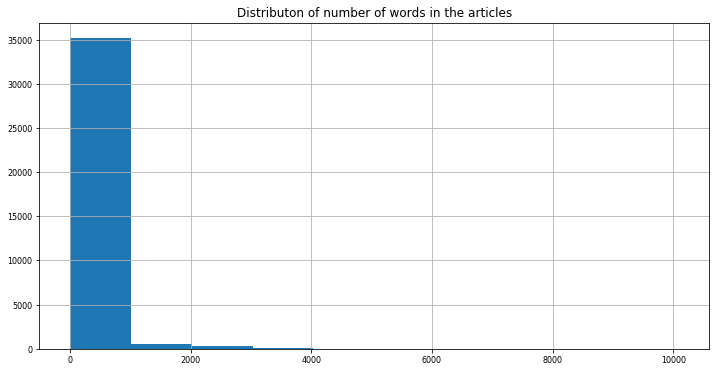

In [38]:
a['length'].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of words in the articles")

In [93]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'imag', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getti", "pa","don","ap","afp","reuter","pictur", "ve", "didn", "share","septemb",
                   "august","octob","jo","thoma","june","juli","fox","bu",
                  "st","ms"]
my_stopwords = SW + stopwords_verbs + stopwords_other

a['clean_text']= a['clean_text'].map(lambda tokens: [token for token in tokens if token not in my_stopwords])

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text,length
0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0,"[man, lay, flower, victim, terror, attack, mem...",9
1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302
2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302
3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr...",467
4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[lord, steel, evid, independ, inquiri, child, ...",378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36087,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns...",384
36088,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ...",134
36089,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, racism, yo...",285
36090,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, vodafon, deal, amazon, ec...",160


In [94]:
data_lemmatized = a['clean_text']

In [95]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out words that occur less than 30 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=500, no_above=0.4)

# Create Corpus
texts = data_lemmatized

In [96]:
corpus = [id2word.doc2bow(text) for text in texts]

In [97]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2277
Number of documents: 36092


### Crime  - Economic situation - Rising prices/inflation/cost of living - Taxation - Unemployment - Terrorism - Housing - Government debt - Immigration - Health and social security - The education system - Pensions - The environment, climate and energy issues  - Brexit

## Build LDA model

In [ ]:
num=21
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=10,
                                                   passes=2,
                                                   alpha=[0.01]*num,
                                                   per_word_topics=True)
print("------------------------------------------------")
print("number of topics" , num)
#    print('\nPerplexity: ', lda_model.log_perplexity(corpus))
print(lda_model.print_topics())


In [110]:

for i,topic in lda_model.show_topics(formatted=True, num_topics=21, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.044*"children" + 0.030*"famili" + 0.029*"women" + 0.028*"school" + 0.022*"daughter" + 0.020*"babi" + 0.019*"parent" + 0.019*"mother" + 0.017*"child" + 0.016*"son" + 0.014*"age" + 0.014*"father" + 0.014*"life" + 0.012*"young" + 0.011*"girl" + 0.009*"men" + 0.009*"sex" + 0.008*"boy" + 0.008*"live" + 0.008*"bear"

1: 0.038*"court" + 0.016*"hear" + 0.015*"case" + 0.015*"drug" + 0.014*"prison" + 0.014*"jail" + 0.014*"abus" + 0.014*"judg" + 0.014*"sentenc" + 0.013*"victim" + 0.013*"month" + 0.012*"claim" + 0.012*"murder" + 0.011*"charg" + 0.010*"alleg" + 0.010*"trial" + 0.010*"sexual" + 0.009*"guilti" + 0.009*"crime" + 0.009*"birthday"

2: 0.026*"love" + 0.025*"star" + 0.019*"tv" + 0.011*"film" + 0.010*"fan" + 0.010*"reveal" + 0.009*"friend" + 0.009*"instagram" + 0.008*"night" + 0.007*"coupl" + 0.007*"pair" + 0.007*"life" + 0.007*"write" + 0.007*"good" + 0.007*"post" + 0.007*"seri" + 0.007*"island" + 0.006*"play" + 0.006*"itv" + 0.006*"actor"

3: 0.068*"protest" + 0.063*"london" + 0.020

In [103]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.058236 -0.200569       1        1  10.167192
19     0.074183 -0.112300       2        1   9.309812
14     0.053451  0.081316       3        1   9.152213
2     -0.012637  0.175214       4        1   8.706821
0      0.032093  0.192739       5        1   6.137949
8     -0.081746  0.096673       6        1   5.956199
9     -0.012287 -0.012536       7        1   5.952611
1      0.012906  0.156271       8        1   5.324190
4      0.193754 -0.142451       9        1   4.586791
16     0.198636 -0.102995      10        1   3.699596
10    -0.049453  0.103050      11        1   3.327122
13     0.178765 -0.028344      12        1   3.276135
5      0.167739  0.032762      13        1   3.275414
15    -0.162693  0.035809      14        1   3.247226
18    -0.029925 -0.165300      15        1   3.095234
11     0.178019  0.031316      16        1   3.016040
3     -0.212331 -0.183116      17        1   2.780935
12    -0.152561  0.039306      18        1   2.744605
7     -0.063371 -0.059305      19        1   2.379688
20    -0.023527  0.095856      20        1   2.277834
6     -0.230781 -0.033397      21        1   1.586397, topic_info=        Term          Freq         Total Category  logprob  loglift
379   credit  23717.000000  23717.000000  Default  30.0000  30.0000
1003  brexit  33417.000000  33417.000000  Default  29.0000  29.0000
262    trump  17239.000000  17239.000000  Default  28.0000  28.0000
225    polic  33626.000000  33626.000000  Default  27.0000  27.0000
0     attack  20773.000000  20773.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
658     unit    993.391785  11180.921875  Topic21  -4.7756   1.7229
431     land    849.832214   6031.206055  Topic21  -4.9317   2.1840
322   leader    945.430115  16105.374023  Topic21  -4.8251   1.3084
76    nation    899.441040  12086.986328  Topic21  -4.8750   1.5456
71     media    809.858704  18324.683594  Topic21  -4.9799   1.0246

[1082 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
275       5  0.073279     abus
275       8  0.905764     abus
275      11  0.020937     abus
1613      5  0.805632  academi
1613      7  0.108407  academi
...     ...       ...      ...
128      11  0.045447  zealand
128      14  0.954384  zealand
1452      2  0.058002     zone
1452      3  0.186126     zone
1452     15  0.755760     zone

[4215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 15, 3, 1, 9, 10, 2, 5, 17, 11, 14, 6, 16, 19, 12, 4, 13, 8, 21, 7])

In [106]:
lda_model[corpus[1]]

([(1, 0.0145369135),
  (2, 0.061714437),
  (10, 0.19549513),
  (14, 0.12340365),
  (15, 0.40568724),
  (17, 0.070333354),
  (19, 0.12813331)],
 [(0, [15]),
  (3, [15, 14, 2, 1, 10]),
  (5, [15]),
  (7, [14, 10, 2, 1]),
  (8, [15]),
  (9, [15, 1, 19]),
  (10, [15, 19, 10, 17]),
  (11, [15, 14]),
  (12, [15, 14, 10]),
  (13, [14, 10, 2, 17]),
  (14, [19, 14, 10, 2, 1]),
  (15, [15, 19, 17, 14]),
  (16, [15, 19]),
  (17, [10, 19, 1, 17]),
  (18, [14, 19, 17, 10, 2]),
  (19, [15, 19]),
  (20, [10, 19, 15, 17, 2, 1]),
  (21, [15, 19, 10]),
  (22, [15, 10, 19]),
  (23, [10, 15, 2, 19, 17]),
  (24, [10, 19, 14, 17]),
  (25, [1, 15]),
  (26, [15, 2]),
  (27, [15, 2, 1]),
  (28, [15, 19, 17, 2, 14]),
  (29, [19, 10]),
  (30, [10, 2]),
  (31, [17]),
  (32, [14, 2, 19, 1]),
  (33, [14, 19]),
  (34, [14, 19]),
  (35, [15, 10, 19, 14, 2, 1]),
  (36, [15, 14, 19, 17]),
  (37, [2]),
  (38, [15, 19, 14, 17]),
  (39, [14, 2, 10]),
  (40, [14, 2, 15, 17, 19]),
  (41, [2, 10, 1]),
  (42, [14, 2, 17, 19, 

In [113]:
lda_model[corpus[5011]]

([(0, 0.087520614),
  (1, 0.039558288),
  (2, 0.28919005),
  (4, 0.053144082),
  (5, 0.12125117),
  (12, 0.044602703),
  (14, 0.11475969),
  (16, 0.065773286),
  (20, 0.18353775)],
 [(27, [5, 2, 1]),
  (39, [2, 14, 5, 0, 16, 1]),
  (42, [14, 2, 20, 1]),
  (69, [2, 14, 1, 5, 0]),
  (70, [2, 0, 5, 1, 14]),
  (95, [5, 16, 1, 12]),
  (164, [14, 16, 4, 1, 2, 20, 0]),
  (174, [2, 16, 12, 14]),
  (183, [14, 2, 0, 12, 16]),
  (198, [2, 0, 5, 14, 20, 16, 1]),
  (199, [16, 4, 14, 2]),
  (205, [0, 5, 1, 2, 14]),
  (213, [5, 14, 2, 20, 16, 1]),
  (258, [2, 14, 0, 1]),
  (264, [20, 4, 5, 16, 2]),
  (267, [20, 2, 12, 0, 1, 14]),
  (271, [20, 0, 2, 1, 12]),
  (273, [2, 5, 0, 14, 4]),
  (287, [0, 2, 1]),
  (302, [5, 14, 2, 4, 16]),
  (319, [2, 4, 14, 0]),
  (341, [5, 14, 2, 0, 4, 1]),
  (347, [20, 14, 0, 5, 2, 1]),
  (349, [2, 5, 0, 1, 14]),
  (379, [20]),
  (383, [20, 2, 16, 5, 14, 1, 0, 4, 12]),
  (401, [16, 14, 2, 0, 5, 4]),
  (406, [5, 4]),
  (410, [20]),
  (415, [20, 2, 16, 0]),
  (422, [20, 2, 1